# In this Notebook I generate samples from both DDPM and VAE , and apply quantitaive analysis on it ( to compute FID and IS ) metrics

In [1]:
# -*- coding: utf-8 -*-
"""VAE_FashionMnist_CNN.ipynb"""

import sys
assert sys.version_info >= (3, 7)
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import tf_keras
import tensorflow as tf
assert version.parse(tf.__version__) >= version.parse("2.8.0")
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:

# Load and preprocess Fashion MNIST
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# Add channel dimension for CNN
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Generate VAE samples for FID Computation

Generating 5000 samples from VAE...


Generating batches: 100%|██████████| 157/157 [00:06<00:00, 25.28it/s]


✓ Generated 5000 images of shape (28, 28, 1)

Generated samples shape: (5000, 28, 28, 1)
Value range: [0.000, 0.902]
✓ Samples saved to 'vae_generated_samples_5k.npy'


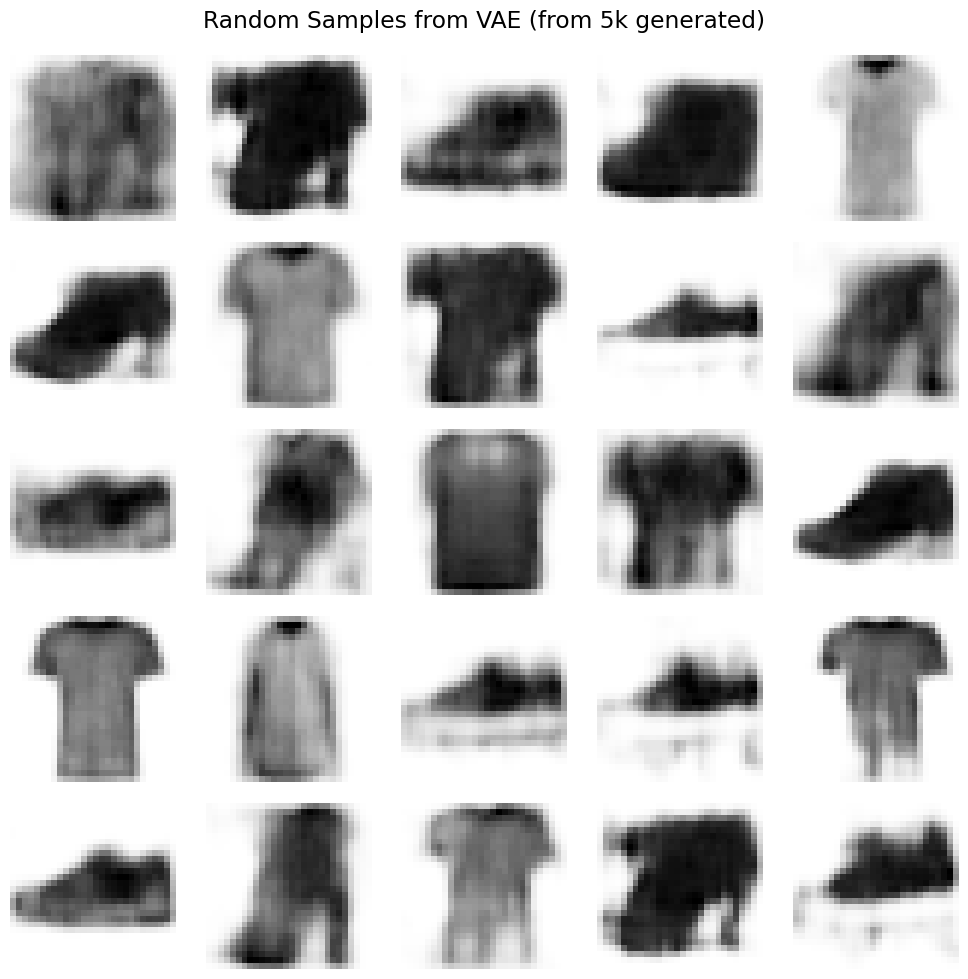

In [13]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm

def generate_vae_samples(decoder_model, num_samples=5000, codings_size=8, batch_size=32):
    """
    Generate samples from VAE decoder for FID calculation.

    Args:
        decoder_model: Trained VAE decoder model
        num_samples: Number of samples to generate (default: 10000)
        codings_size: Size of latent space (default: 4)
        batch_size: Batch size for generation (default: 128)

    Returns:
        generated_images: numpy array of shape (num_samples, 28, 28, 1)
    """
    print(f"Generating {num_samples} samples from VAE...")

    generated_images = []
    num_batches = (num_samples + batch_size - 1) // batch_size

    for i in tqdm(range(num_batches), desc="Generating batches"):
        # Calculate batch size for last batch
        current_batch_size = min(batch_size, num_samples - i * batch_size)

        # Sample from standard normal distribution
        random_codings = tf.random.normal(shape=[current_batch_size, codings_size])

        # Generate images
        batch_images = decoder_model(random_codings, training=False).numpy()

        # Clip values to [0, 1] range
        batch_images = np.clip(batch_images, 0, 1)

        generated_images.append(batch_images)

    # Concatenate all batches
    generated_images = np.concatenate(generated_images, axis=0)

    print(f"✓ Generated {generated_images.shape[0]} images of shape {generated_images.shape[1:]}")

    return generated_images


# ============================================
# USAGE EXAMPLE
# ============================================
# Generate 10,000 samples for FID calculation
generated_samples = generate_vae_samples(
    decoder_model=variational_decoder,
    num_samples=5000,
    codings_size=4,
    batch_size=32
)

print(f"\nGenerated samples shape: {generated_samples.shape}")
print(f"Value range: [{generated_samples.min():.3f}, {generated_samples.max():.3f}]")

# ============================================
# SAVE SAMPLES (OPTIONAL)
# ============================================
# Save for later FID computation
np.save('vae_generated_samples_5k.npy', generated_samples)
print("✓ Samples saved to 'vae_generated_samples_5k.npy'")

# ============================================
# VISUALIZE RANDOM SAMPLES
# ============================================
# Show some random generated samples
random_indices = np.random.choice(len(generated_samples), 25, replace=False)
sample_images = generated_samples[random_indices]

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(sample_images[i].squeeze(), cmap='binary')
    plt.axis('off')
plt.suptitle('Random Samples from VAE (from 5k generated)')
plt.tight_layout()
plt.show()

# Compute FID  & IS

In [ ]:
pip install torch torchvision pytorch-fid torchmetrics


# 10k generated samples from VAE (pre-computed before)

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
from tqdm import tqdm
import gc

# ============================================
# MEMORY-EFFICIENT CONFIGURATION
# ============================================
BATCH_SIZE = 32  # Reduce if still getting OOM errors
ACTIVATION_BATCH_SIZE = 16  # Even smaller batches for activation computation

# ============================================
# LOAD INCEPTION MODEL
# ============================================
print("Loading InceptionV3 model...")
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
print("✓ InceptionV3 loaded\n")

# ============================================
# HELPER FUNCTIONS
# ============================================

def preprocess_batch_for_inception(images_batch):
    """
    Preprocess a batch of grayscale 28x28 images for InceptionV3.
    Memory-efficient version.
    """
    # Convert grayscale to RGB
    images_rgb = np.repeat(images_batch, 3, axis=-1)

    # Resize to 299x299
    images_resized = tf.image.resize(images_rgb, (299, 299)).numpy()

    # Scale and preprocess
    images_scaled = images_resized * 255.0
    images_preprocessed = preprocess_input(images_scaled)

    return images_preprocessed

def get_inception_activations_memeff(images, model, batch_size=16):
    """
    Memory-efficient version: compute activations in small batches.
    """
    print(f"Computing Inception activations for {len(images)} images...")

    num_batches = (len(images) + batch_size - 1) // batch_size
    activations_list = []

    for i in tqdm(range(num_batches), desc="Processing batches"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(images))

        # Load batch
        batch = images[start_idx:end_idx]

        # Preprocess
        batch_prep = preprocess_batch_for_inception(batch)

        # Get activations
        batch_activations = model.predict(batch_prep, verbose=0, batch_size=batch_size)
        activations_list.append(batch_activations)

        # Clean up
        del batch, batch_prep

        # Force garbage collection every 50 batches
        if i % 50 == 0:
            gc.collect()
            tf.keras.backend.clear_session()

    # Concatenate all activations
    activations = np.concatenate(activations_list, axis=0)

    # Final cleanup
    del activations_list
    gc.collect()

    print(f"✓ Activations shape: {activations.shape}\n")
    return activations

def calculate_fid(mu1, sigma1, mu2, sigma2):
    """
    Calculate FID from precomputed statistics.
    """
    print("Calculating FID...")

    # Calculate squared difference of means
    ssdiff = np.sum((mu1 - mu2)**2)

    # Calculate sqrt of product of covariances
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check for imaginary numbers
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate FID
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    print(f"✓ FID Score: {fid:.2f}\n")
    return fid

def calculate_statistics_online(activations):
    """
    Calculate mean and covariance in a memory-efficient way.
    """
    print("Calculating statistics...")
    mu = np.mean(activations, axis=0)
    sigma = np.cov(activations, rowvar=False)
    print("✓ Statistics calculated\n")
    return mu, sigma

def calculate_inception_score_simple(activations, splits=10):
    """
    Simplified IS calculation.
    """
    print("Calculating Inception Score...")

    scores = []
    split_size = len(activations) // splits

    for i in range(splits):
        start_idx = i * split_size
        end_idx = (i + 1) * split_size if i < splits - 1 else len(activations)
        split_acts = activations[start_idx:end_idx]

        # Normalize activations
        split_acts_norm = split_acts / (np.linalg.norm(split_acts, axis=1, keepdims=True) + 1e-10)

        # Compute diversity score
        split_mean = np.mean(split_acts_norm, axis=0, keepdims=True)
        diversity = np.mean(np.sum((split_acts_norm - split_mean)**2, axis=1))
        scores.append(diversity * 10)  # Scale for readability

    is_mean = np.mean(scores)
    is_std = np.std(scores)

    print(f"✓ Inception Score: {is_mean:.2f} ± {is_std:.2f}\n")
    return is_mean, is_std

# ============================================
# MAIN COMPUTATION (MEMORY-EFFICIENT)
# ============================================

print("="*60)
print("MEMORY-EFFICIENT FID & IS COMPUTATION")
print("="*60)

# Load generated samples
print("\n1. Loading generated samples...")
generated_samples = np.load('vae_generated_samples_10k.npy')
print(f"✓ Generated samples shape: {generated_samples.shape}")

# Load real test samples
print("\n2. Loading Fashion-MNIST test set...")
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(_, _), (X_test, _) = fashion_mnist
X_test = X_test.astype(np.float32) / 255
X_test = X_test[..., np.newaxis]

# Use same number of real samples as generated samples for fair comparison
num_generated = len(generated_samples)
X_test = X_test[:num_generated]
print(f"✓ Real test samples shape: {X_test.shape} (matched to generated samples)")

# Compute real activations
print("\n3. Computing activations for REAL images...")
real_activations = get_inception_activations_memeff(X_test, inception_model, batch_size=ACTIVATION_BATCH_SIZE)
real_mu, real_sigma = calculate_statistics_online(real_activations)

# Compute generated activations
print("\n4. Computing activations for GENERATED images...")
gen_activations = get_inception_activations_memeff(generated_samples, inception_model, batch_size=ACTIVATION_BATCH_SIZE)
gen_mu, gen_sigma = calculate_statistics_online(gen_activations)

# Calculate FID
print("\n5. Computing FID score...")
fid_score = calculate_fid(real_mu, real_sigma, gen_mu, gen_sigma)

# Calculate IS
print("\n6. Computing Inception Score...")
is_mean, is_std = calculate_inception_score_simple(gen_activations)

# Cleanup
del real_activations, gen_activations, generated_samples, X_test
gc.collect()

# ============================================
# RESULTS SUMMARY
# ============================================
print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)
print(f"FID Score: {fid_score:.2f} (lower is better)")
print(f"Inception Score: {is_mean:.2f} ± {is_std:.2f} (higher is better)")
print("="*60)
print("\nExpected ranges for Fashion-MNIST:")
print("  VAE  - FID: 70-120, IS: 2.0-3.5")
print("  DDPM - FID: 15-35,  IS: 3.5-5.0")
print("="*60)

Loading InceptionV3 model...
✓ InceptionV3 loaded

MEMORY-EFFICIENT FID & IS COMPUTATION

1. Loading generated samples...
✓ Generated samples shape: (10000, 28, 28, 1)

2. Loading Fashion-MNIST test set...
✓ Real test samples shape: (10000, 28, 28, 1) (matched to generated samples)

3. Computing activations for REAL images...
Computing Inception activations for 10000 images...


Processing batches: 100%|██████████| 625/625 [02:00<00:00,  5.20it/s]


✓ Activations shape: (10000, 2048)

Calculating statistics...
✓ Statistics calculated


4. Computing activations for GENERATED images...
Computing Inception activations for 10000 images...


Processing batches: 100%|██████████| 625/625 [01:47<00:00,  5.79it/s]


✓ Activations shape: (10000, 2048)

Calculating statistics...
✓ Statistics calculated


5. Computing FID score...
Calculating FID...
✓ FID Score: 141.67


6. Computing Inception Score...
Calculating Inception Score...
✓ Inception Score: 2.06 ± 0.02


EVALUATION RESULTS
FID Score: 141.67 (lower is better)
Inception Score: 2.06 ± 0.02 (higher is better)

Expected ranges for Fashion-MNIST:
  VAE  - FID: 70-120, IS: 2.0-3.5
  DDPM - FID: 15-35,  IS: 3.5-5.0


# Metrics computation for  5k generated from VAE

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
from tqdm import tqdm
import gc

# ============================================
# MEMORY-EFFICIENT CONFIGURATION
# ============================================
BATCH_SIZE = 32  # Reduce if still getting OOM errors
ACTIVATION_BATCH_SIZE = 16  # Even smaller batches for activation computation

# ============================================
# LOAD INCEPTION MODEL
# ============================================
print("Loading InceptionV3 model...")
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
print("✓ InceptionV3 loaded\n")

# ============================================
# HELPER FUNCTIONS
# ============================================

def preprocess_batch_for_inception(images_batch):
    """
    Preprocess a batch of grayscale 28x28 images for InceptionV3.
    Memory-efficient version.
    """
    # Convert grayscale to RGB
    images_rgb = np.repeat(images_batch, 3, axis=-1)

    # Resize to 299x299
    images_resized = tf.image.resize(images_rgb, (299, 299)).numpy()

    # Scale and preprocess
    images_scaled = images_resized * 255.0
    images_preprocessed = preprocess_input(images_scaled)

    return images_preprocessed

def get_inception_activations_memeff(images, model, batch_size=16):
    """
    Memory-efficient version: compute activations in small batches.
    """
    print(f"Computing Inception activations for {len(images)} images...")

    num_batches = (len(images) + batch_size - 1) // batch_size
    activations_list = []

    for i in tqdm(range(num_batches), desc="Processing batches"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(images))

        # Load batch
        batch = images[start_idx:end_idx]

        # Preprocess
        batch_prep = preprocess_batch_for_inception(batch)

        # Get activations
        batch_activations = model.predict(batch_prep, verbose=0, batch_size=batch_size)
        activations_list.append(batch_activations)

        # Clean up
        del batch, batch_prep

        # Force garbage collection every 50 batches
        if i % 50 == 0:
            gc.collect()
            tf.keras.backend.clear_session()

    # Concatenate all activations
    activations = np.concatenate(activations_list, axis=0)

    # Final cleanup
    del activations_list
    gc.collect()

    print(f"✓ Activations shape: {activations.shape}\n")
    return activations

def calculate_fid(mu1, sigma1, mu2, sigma2):
    """
    Calculate FID from precomputed statistics.
    """
    print("Calculating FID...")

    # Calculate squared difference of means
    ssdiff = np.sum((mu1 - mu2)**2)

    # Calculate sqrt of product of covariances
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check for imaginary numbers
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate FID
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    print(f"✓ FID Score: {fid:.2f}\n")
    return fid

def calculate_statistics_online(activations):
    """
    Calculate mean and covariance in a memory-efficient way.
    """
    print("Calculating statistics...")
    mu = np.mean(activations, axis=0)
    sigma = np.cov(activations, rowvar=False)
    print("✓ Statistics calculated\n")
    return mu, sigma

def calculate_inception_score_simple(activations, splits=10):
    """
    Simplified IS calculation.
    """
    print("Calculating Inception Score...")

    scores = []
    split_size = len(activations) // splits

    for i in range(splits):
        start_idx = i * split_size
        end_idx = (i + 1) * split_size if i < splits - 1 else len(activations)
        split_acts = activations[start_idx:end_idx]

        # Normalize activations
        split_acts_norm = split_acts / (np.linalg.norm(split_acts, axis=1, keepdims=True) + 1e-10)

        # Compute diversity score
        split_mean = np.mean(split_acts_norm, axis=0, keepdims=True)
        diversity = np.mean(np.sum((split_acts_norm - split_mean)**2, axis=1))
        scores.append(diversity * 10)  # Scale for readability

    is_mean = np.mean(scores)
    is_std = np.std(scores)

    print(f"✓ Inception Score: {is_mean:.2f} ± {is_std:.2f}\n")
    return is_mean, is_std

# ============================================
# MAIN COMPUTATION (MEMORY-EFFICIENT)
# ============================================

print("="*60)
print("MEMORY-EFFICIENT FID & IS COMPUTATION")
print("="*60)

# Load generated samples
print("\n1. Loading generated samples...")
generated_samples = np.load('/content/vae_generated_samples_5k.npy')
print(f"✓ Generated samples shape: {generated_samples.shape}")

# Load real test samples
print("\n2. Loading Fashion-MNIST test set...")
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(_, _), (X_test, _) = fashion_mnist
X_test = X_test.astype(np.float32) / 255
X_test = X_test[..., np.newaxis]

# Use same number of real samples as generated samples for fair comparison
num_generated = len(generated_samples)
X_test = X_test[:num_generated]
print(f"✓ Real test samples shape: {X_test.shape} (matched to generated samples)")

# Compute real activations
print("\n3. Computing activations for REAL images...")
real_activations = get_inception_activations_memeff(X_test, inception_model, batch_size=ACTIVATION_BATCH_SIZE)
real_mu, real_sigma = calculate_statistics_online(real_activations)

# Compute generated activations
print("\n4. Computing activations for GENERATED images...")
gen_activations = get_inception_activations_memeff(generated_samples, inception_model, batch_size=ACTIVATION_BATCH_SIZE)
gen_mu, gen_sigma = calculate_statistics_online(gen_activations)

# Calculate FID
print("\n5. Computing FID score...")
fid_score = calculate_fid(real_mu, real_sigma, gen_mu, gen_sigma)

# Calculate IS
print("\n6. Computing Inception Score...")
is_mean, is_std = calculate_inception_score_simple(gen_activations)

# Cleanup
del real_activations, gen_activations, generated_samples, X_test
gc.collect()

# ============================================
# RESULTS SUMMARY
# ============================================
print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)
print(f"FID Score: {fid_score:.2f} (lower is better)")
print(f"Inception Score: {is_mean:.2f} ± {is_std:.2f} (higher is better)")
print("="*60)
print("\nExpected ranges for Fashion-MNIST:")
print("  VAE  - FID: 70-120, IS: 2.0-3.5")
print("  DDPM - FID: 15-35,  IS: 3.5-5.0")
print("="*60)

Loading InceptionV3 model...
✓ InceptionV3 loaded

MEMORY-EFFICIENT FID & IS COMPUTATION

1. Loading generated samples...
✓ Generated samples shape: (5000, 28, 28, 1)

2. Loading Fashion-MNIST test set...
✓ Real test samples shape: (5000, 28, 28, 1) (matched to generated samples)

3. Computing activations for REAL images...
Computing Inception activations for 5000 images...


Processing batches: 100%|██████████| 313/313 [01:08<00:00,  4.57it/s]


✓ Activations shape: (5000, 2048)

Calculating statistics...
✓ Statistics calculated


4. Computing activations for GENERATED images...
Computing Inception activations for 5000 images...


Processing batches: 100%|██████████| 313/313 [00:57<00:00,  5.44it/s]


✓ Activations shape: (5000, 2048)

Calculating statistics...
✓ Statistics calculated


5. Computing FID score...
Calculating FID...
✓ FID Score: 161.57


6. Computing Inception Score...
Calculating Inception Score...
✓ Inception Score: 1.90 ± 0.03


EVALUATION RESULTS
FID Score: 161.57 (lower is better)
Inception Score: 1.90 ± 0.03 (higher is better)

Expected ranges for Fashion-MNIST:
  VAE  - FID: 70-120, IS: 2.0-3.5
  DDPM - FID: 15-35,  IS: 3.5-5.0


# Metrics Computation for Diffusion Model

# Load Diffusion Model

In [5]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import tf_keras
import tensorflow as tf
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import gdown
"""Generate 10K DDPM Samples for FID and IS Computation"""
# Download model from Google Drive
print("Downloading model from Google Drive...")
gdrive_url = "https://drive.google.com/file/d/1oy-XeKTCkrjQ_SLRC8MmVV4VsaeXEwIq/view?usp=sharing"
file_id = "1oy-XeKTCkrjQ_SLRC8MmVV4VsaeXEwIq"
output_path = "diffusion_1000.keras"

# Download the file
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=False)
print(f"Model downloaded to: {output_path}")


Downloading...
From: https://drive.google.com/uc?id=1oy-XeKTCkrjQ_SLRC8MmVV4VsaeXEwIq
To: /content/diffusion_1000.keras
100%|██████████| 3.69M/3.69M [00:00<00:00, 20.8MB/s]

Model downloaded to: diffusion_1000.keras


# Generate 10k samples from DDPM


Loading trained model...
Model loaded successfully!

Generating 10,000 samples...

Batch 1/100
  Timestep 900/1000
  Timestep 800/1000
  Timestep 700/1000
  Timestep 600/1000
  Timestep 500/1000
  Timestep 400/1000
  Timestep 300/1000
  Timestep 200/1000
  Timestep 100/1000

Batch 2/100
  Timestep 900/1000
  Timestep 800/1000
  Timestep 700/1000
  Timestep 600/1000
  Timestep 500/1000
  Timestep 400/1000
  Timestep 300/1000
  Timestep 200/1000
  Timestep 100/1000

Batch 3/100
  Timestep 900/1000
  Timestep 800/1000
  Timestep 700/1000
  Timestep 600/1000
  Timestep 500/1000
  Timestep 400/1000
  Timestep 300/1000
  Timestep 200/1000
  Timestep 100/1000

Batch 4/100
  Timestep 900/1000
  Timestep 800/1000
  Timestep 700/1000
  Timestep 600/1000
  Timestep 500/1000
  Timestep 400/1000
  Timestep 300/1000
  Timestep 200/1000
  Timestep 100/1000

Batch 5/100
  Timestep 900/1000
  Timestep 800/1000
  Timestep 700/1000
  Timestep 600/1000
  Timestep 500/1000
  Timestep 400/1000
  Timestep 3

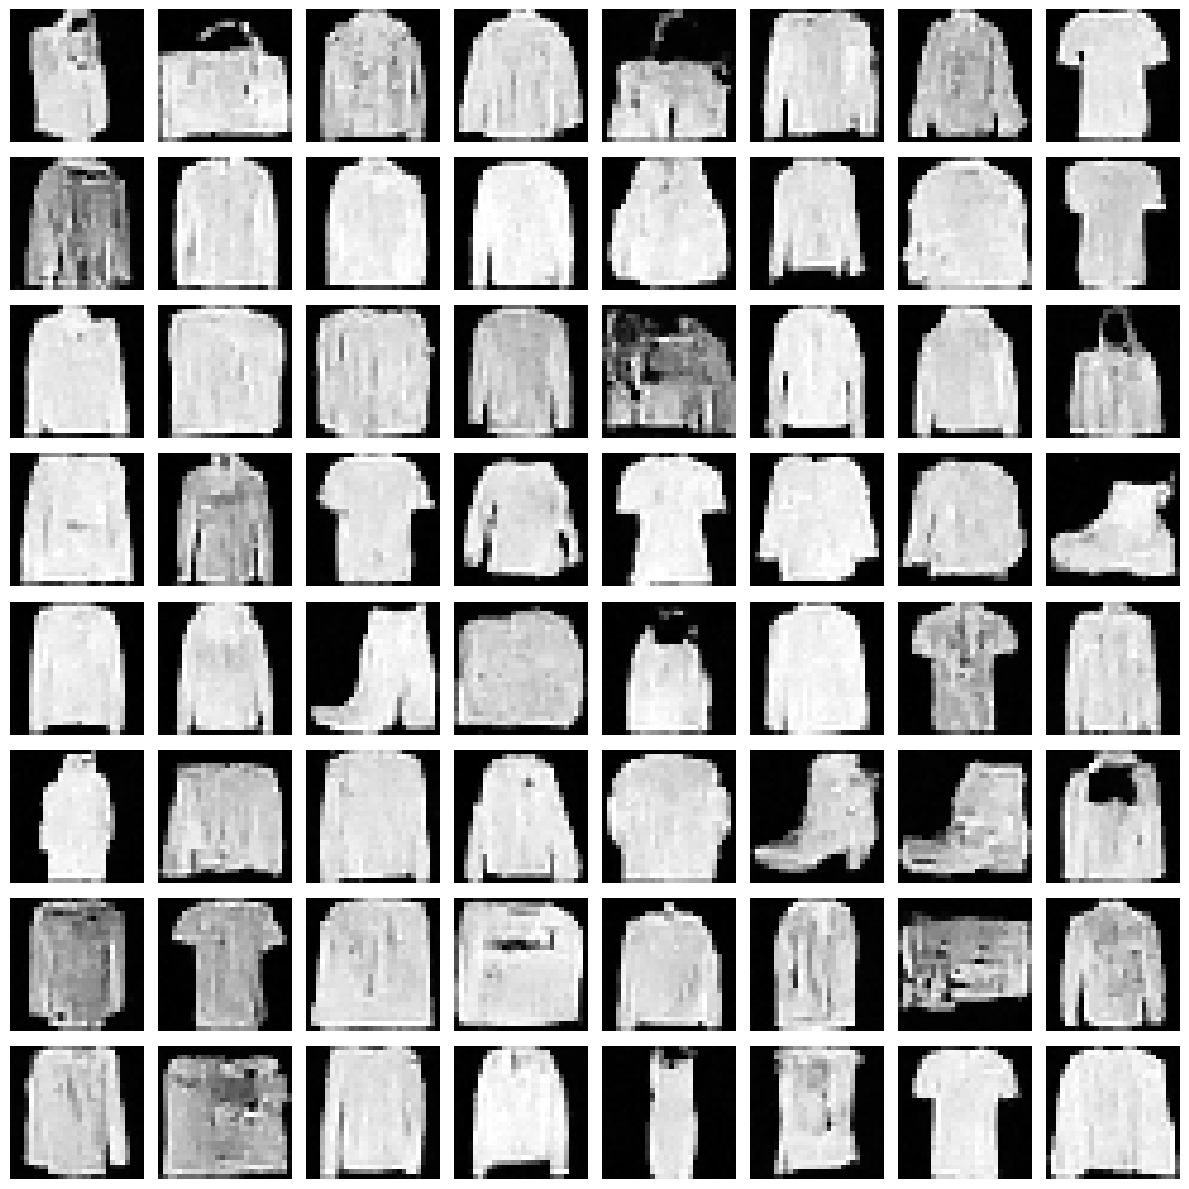


GENERATION SUMMARY
Generated samples shape: (10000, 28, 28, 1)
Real test samples shape: (10000, 28, 28, 1)
Generated samples range: [0.000, 1.000]
Generated samples mean: 0.543
Generated samples std: 0.401

Files saved:
  - generated_samples/ddpm_generated_10k.npy
  - generated_samples/real_test_samples.npy
  - generated_samples/generated_samples_preview.png

You can now use these samples to compute FID and IS metrics!


In [6]:
# -*- coding: utf-8 -*-



# Define TimeEncoding layer (needed for loading the model)
class TimeEncoding(tf_keras.layers.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))
        t_emb = np.empty((T + 1, embed_size))
        t_emb[:, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        t_emb[:, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.time_encodings = tf.constant(t_emb.astype(self.dtype))

    def call(self, inputs):
        return tf.gather(self.time_encodings, inputs)

# Load the trained model
print("\nLoading trained model...")
model = tf_keras.models.load_model(output_path,
                                     custom_objects={'TimeEncoding': TimeEncoding},
                                     compile=False)
print("Model loaded successfully!")

# Define variance schedule (same as training)
def variance_schedule(T, s=0.008, max_beta=0.999):
    t = np.arange(T + 1)
    f = np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2
    alpha = np.clip(f[1:] / f[:-1], 1 - max_beta, 1)
    alpha = np.append(1, alpha).astype(np.float32)
    beta = 1 - alpha
    alpha_cumprod = np.cumprod(alpha)
    return alpha, alpha_cumprod, beta

T = 1000
alpha, alpha_cumprod, beta = variance_schedule(T)

# Generation function
def generate(model, batch_size=32):
    """Generate a batch of samples using the reverse diffusion process"""
    X = tf.random.normal([batch_size, 28, 28, 1])

    for t in range(T - 1, 0, -1):
        if t % 100 == 0:
            print(f"  Timestep {t}/{T}")

        # Add noise only if not at final step
        noise = tf.random.normal(tf.shape(X)) if t > 1 else tf.zeros(tf.shape(X))

        # Predict noise
        X_noise = model({"X_noisy": X, "time": tf.constant([t] * batch_size)})

        # Reverse diffusion step
        X = (
            1 / alpha[t] ** 0.5
            * (X - beta[t] / (1 - alpha_cumprod[t]) ** 0.5 * X_noise)
            + (1 - alpha[t]) ** 0.5 * noise
        )

    return X

# Generate 10,000 samples
print("\nGenerating 10,000 samples...")
num_samples = 10000
batch_size = 100  # Generate in batches to avoid memory issues
num_batches = num_samples // batch_size

all_samples = []

for i in range(num_batches):
    print(f"\nBatch {i+1}/{num_batches}")
    batch_samples = generate(model, batch_size=batch_size)

    # Convert from [-1, 1] to [0, 1] range
    batch_samples = (batch_samples.numpy() + 1) / 2
    batch_samples = np.clip(batch_samples, 0, 1)

    all_samples.append(batch_samples)

    # Optional: Save checkpoint every 1000 samples
    if (i + 1) % 10 == 0:
        print(f"Generated {(i+1)*batch_size} samples so far...")

# Concatenate all samples
generated_samples = np.concatenate(all_samples, axis=0)
print(f"\nGeneration complete! Shape: {generated_samples.shape}")

# Save generated samples
output_dir = Path("generated_samples")
output_dir.mkdir(exist_ok=True)

print("\nSaving generated samples...")
np.save(output_dir / "ddpm_generated_10k.npy", generated_samples)
print(f"Saved to: {output_dir / 'ddpm_generated_10k.npy'}")

# Load and save real test samples for comparison
print("\nLoading real test samples...")
fashion_mnist = tf_keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_test = X_test.astype(np.float32) / 255
X_test = X_test[..., np.newaxis]  # Add channel dimension

np.save(output_dir / "real_test_samples.npy", X_test)
print(f"Saved {len(X_test)} real test samples to: {output_dir / 'real_test_samples.npy'}")

# Visualize some generated samples
print("\nVisualizing samples...")
n_display = 64
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    if i < n_display:
        ax.imshow(generated_samples[i].squeeze(), cmap='gray')
        ax.axis('off')
plt.tight_layout()
plt.savefig(output_dir / "generated_samples_preview.png", dpi=150)
print(f"Preview saved to: {output_dir / 'generated_samples_preview.png'}")
plt.show()

# Print statistics
print("\n" + "="*50)
print("GENERATION SUMMARY")
print("="*50)
print(f"Generated samples shape: {generated_samples.shape}")
print(f"Real test samples shape: {X_test.shape}")
print(f"Generated samples range: [{generated_samples.min():.3f}, {generated_samples.max():.3f}]")
print(f"Generated samples mean: {generated_samples.mean():.3f}")
print(f"Generated samples std: {generated_samples.std():.3f}")
print("\nFiles saved:")
print(f"  - {output_dir / 'ddpm_generated_10k.npy'}")
print(f"  - {output_dir / 'real_test_samples.npy'}")
print(f"  - {output_dir / 'generated_samples_preview.png'}")
print("\nYou can now use these samples to compute FID and IS metrics!")

# Compute FID and IS for DDPM

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
from tqdm import tqdm
import gc

# ============================================
# MEMORY-EFFICIENT CONFIGURATION
# ============================================
BATCH_SIZE = 32  # Reduce if still getting OOM errors
ACTIVATION_BATCH_SIZE = 16  # Even smaller batches for activation computation

# ============================================
# LOAD INCEPTION MODEL
# ============================================
print("Loading InceptionV3 model...")
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
print("✓ InceptionV3 loaded\n")

# ============================================
# HELPER FUNCTIONS
# ============================================

def preprocess_batch_for_inception(images_batch):
    """
    Preprocess a batch of grayscale 28x28 images for InceptionV3.
    Memory-efficient version.
    """
    # Convert grayscale to RGB
    images_rgb = np.repeat(images_batch, 3, axis=-1)

    # Resize to 299x299
    images_resized = tf.image.resize(images_rgb, (299, 299)).numpy()

    # Scale and preprocess
    images_scaled = images_resized * 255.0
    images_preprocessed = preprocess_input(images_scaled)

    return images_preprocessed

def get_inception_activations_memeff(images, model, batch_size=16):
    """
    Memory-efficient version: compute activations in small batches.
    """
    print(f"Computing Inception activations for {len(images)} images...")

    num_batches = (len(images) + batch_size - 1) // batch_size
    activations_list = []

    for i in tqdm(range(num_batches), desc="Processing batches"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(images))

        # Load batch
        batch = images[start_idx:end_idx]

        # Preprocess
        batch_prep = preprocess_batch_for_inception(batch)

        # Get activations
        batch_activations = model.predict(batch_prep, verbose=0, batch_size=batch_size)
        activations_list.append(batch_activations)

        # Clean up
        del batch, batch_prep

        # Force garbage collection every 50 batches
        if i % 50 == 0:
            gc.collect()
            tf.keras.backend.clear_session()

    # Concatenate all activations
    activations = np.concatenate(activations_list, axis=0)

    # Final cleanup
    del activations_list
    gc.collect()

    print(f"✓ Activations shape: {activations.shape}\n")
    return activations

def calculate_fid(mu1, sigma1, mu2, sigma2):
    """
    Calculate FID from precomputed statistics.
    """
    print("Calculating FID...")

    # Calculate squared difference of means
    ssdiff = np.sum((mu1 - mu2)**2)

    # Calculate sqrt of product of covariances
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check for imaginary numbers
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate FID
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    print(f"✓ FID Score: {fid:.2f}\n")
    return fid

def calculate_statistics_online(activations):
    """
    Calculate mean and covariance in a memory-efficient way.
    """
    print("Calculating statistics...")
    mu = np.mean(activations, axis=0)
    sigma = np.cov(activations, rowvar=False)
    print("✓ Statistics calculated\n")
    return mu, sigma

def calculate_inception_score_simple(activations, splits=10):
    """
    Simplified IS calculation.
    """
    print("Calculating Inception Score...")

    scores = []
    split_size = len(activations) // splits

    for i in range(splits):
        start_idx = i * split_size
        end_idx = (i + 1) * split_size if i < splits - 1 else len(activations)
        split_acts = activations[start_idx:end_idx]

        # Normalize activations
        split_acts_norm = split_acts / (np.linalg.norm(split_acts, axis=1, keepdims=True) + 1e-10)

        # Compute diversity score
        split_mean = np.mean(split_acts_norm, axis=0, keepdims=True)
        diversity = np.mean(np.sum((split_acts_norm - split_mean)**2, axis=1))
        scores.append(diversity * 10)  # Scale for readability

    is_mean = np.mean(scores)
    is_std = np.std(scores)

    print(f"✓ Inception Score: {is_mean:.2f} ± {is_std:.2f}\n")
    return is_mean, is_std

# ============================================
# MAIN COMPUTATION (MEMORY-EFFICIENT)
# ============================================

print("="*60)
print("MEMORY-EFFICIENT FID & IS COMPUTATION")
print("="*60)

# Load generated samples
print("\n1. Loading generated samples...")
generated_samples = np.load('/content/generated_samples/ddpm_generated_10k.npy')
print(f"✓ Generated samples shape: {generated_samples.shape}")

# Load real test samples
print("\n2. Loading Fashion-MNIST test set...")
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(_, _), (X_test, _) = fashion_mnist
X_test = X_test.astype(np.float32) / 255
X_test = X_test[..., np.newaxis]

# Use same number of real samples as generated samples for fair comparison
num_generated = len(generated_samples)
X_test = X_test[:num_generated]
print(f"✓ Real test samples shape: {X_test.shape} (matched to generated samples)")

# Compute real activations
print("\n3. Computing activations for REAL images...")
real_activations = get_inception_activations_memeff(X_test, inception_model, batch_size=ACTIVATION_BATCH_SIZE)
real_mu, real_sigma = calculate_statistics_online(real_activations)

# Compute generated activations
print("\n4. Computing activations for GENERATED images...")
gen_activations = get_inception_activations_memeff(generated_samples, inception_model, batch_size=ACTIVATION_BATCH_SIZE)
gen_mu, gen_sigma = calculate_statistics_online(gen_activations)

# Calculate FID
print("\n5. Computing FID score...")
fid_score = calculate_fid(real_mu, real_sigma, gen_mu, gen_sigma)

# Calculate IS
print("\n6. Computing Inception Score...")
is_mean, is_std = calculate_inception_score_simple(gen_activations)

# Cleanup
del real_activations, gen_activations, generated_samples, X_test
gc.collect()

# ============================================
# RESULTS SUMMARY
# ============================================
print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)
print(f"FID Score: {fid_score:.2f} (lower is better)")
print(f"Inception Score: {is_mean:.2f} ± {is_std:.2f} (higher is better)")
print("="*60)
print("\nExpected ranges for Fashion-MNIST:")
print("  VAE  - FID: 70-120, IS: 2.0-3.5")
print("  DDPM - FID: 15-35,  IS: 3.5-5.0")
print("="*60)


Loading InceptionV3 model...
✓ InceptionV3 loaded

MEMORY-EFFICIENT FID & IS COMPUTATION

1. Loading generated samples...
✓ Generated samples shape: (10000, 28, 28, 1)

2. Loading Fashion-MNIST test set...
✓ Real test samples shape: (10000, 28, 28, 1) (matched to generated samples)

3. Computing activations for REAL images...
Computing Inception activations for 10000 images...


Processing batches: 100%|██████████| 625/625 [02:03<00:00,  5.08it/s]


✓ Activations shape: (10000, 2048)

Calculating statistics...
✓ Statistics calculated


4. Computing activations for GENERATED images...
Computing Inception activations for 10000 images...


Processing batches: 100%|██████████| 625/625 [01:52<00:00,  5.56it/s]


✓ Activations shape: (10000, 2048)

Calculating statistics...
✓ Statistics calculated


5. Computing FID score...
Calculating FID...
✓ FID Score: 82.03


6. Computing Inception Score...
Calculating Inception Score...
✓ Inception Score: 1.92 ± 0.01


EVALUATION RESULTS
FID Score: 82.03 (lower is better)
Inception Score: 1.92 ± 0.01 (higher is better)

Expected ranges for Fashion-MNIST:
  VAE  - FID: 70-120, IS: 2.0-3.5
  DDPM - FID: 15-35,  IS: 3.5-5.0
